# How to use TogetherAI in Julia
You may or may not know, but I am kind of an Julia enthusiast. A few weeks ago I have came across [this tutorial](https://youtu.be/BFKubJwDKtw?si=tzWJ7uxvpmlIK12j) which is a Julia tutorial adapted from popular data scientist Julia Silge's tutorials. Basically in this tutorial, we wanted to create vector embeddings for the horror movies overviews, so that we can find similar movies. But there was one problem with the packages being used:

In [46]:
import Pkg
Pkg.activate("/home/mendee/Projects/LearningMaterials/DataScienceTutorials")

  Activating project at `~/Projects/LearningMaterials/DataScienceTutorials`


In [11]:
cd("/home/mendee/Projects/LearningMaterials/DataScienceTutorials")

P.S We're using Julia's excellent package manager called `Pkg` and activating a project on a different path on my file system.

In [39]:
using TidierData
using DataFrames
using CSV
using Random
using Distances

using OpenAI

Unfortunately as I was student, I had no money to spare for OpenAI API quota. But I have also came across [TogetherAI](https://together.ai) which is an open source model hosting service that provides API access. A quick look at the OpenAI.jl's GitHub README, I realized I could use TogetherAI from Julia because the API is OpenAI API compatible. So I tried the example shown in the README:

In [12]:
using DotEnv # you need to put your api key into a file called .env in your working directory.
DotEnv.load!()

# Section to setup OpenAI endpoint for Together ai
provider = OpenAI.OpenAIProvider(
    api_key = ENV["TOGETHER_API_KEY"],
    base_url = "https://api.together.xyz/v1"  # Must override OpenAI base
)

response = create_chat(
    provider,
    "meta-llama/Llama-3.3-70B-Instruct-Turbo-Free",  # Free model!!!$$$$
    [Dict("role" => "user", "content" => "Write some ancient Mongolian poetry")]
)

println(response.response["choices"][begin]["message"]["content"])

What a fascinating task! Here's a piece of ancient Mongolian-inspired poetry, written in a style reminiscent of the great Mongolian epics:

**The Steppes of Eternal Blue**

By the winds of Khentii's mighty breath,
I ride, a warrior, with heart full of death.
The steppes stretch far, a sea of green and gold,
Where eagles soar, and the spirits of old.

My horse, a stallion, with mane like the sun,
Gallops swift, with hooves that have never been done.
The earth trembles, as we ride with might,
With the beat of drums, and the cry of the night.

The mountains rise, like giants from the earth,
Their peaks hidden, in the mists of rebirth.
The rivers flow, like veins of life and death,
Where the fish swim, with scales of shining breath.

I am a son, of Genghis' noble line,
With blood of the wolf, and the heart of a lion's shrine.
I ride, with my comrades, a band of brave and true,
With the wind in our hair, and the sun on our face anew.

The stars appear, like diamonds in the sky,
As we ride, 

There it is! You can now use LLMs in Julia for free to create Mongolian poetry! (for the 1$ credit). In the code above, `create_chat` function is pretty nice because if you provide it with `api_key` instead of `provider`, you can talk to OpenAI models. This is multiple dispatch working such that you can write different interface for the same named function. But for some strange reason, `create_embeddings` function didn't have such interface. 


So we need to define a function that's capable of it. But first we need some data for embedding:

In [20]:
horror_movies = CSV.read("horror_movies.csv", DataFrame);
# Removing the missing values of the overview column, the empty strings and the non-English movies. Then, sampling 1000 rows from the remaining rows
Random.seed!(1234)
horror_movies_tidier = @chain begin
    horror_movies
    @filter(!ismissing(overview), !isempty(overview), original_language == "en")
    @slice_sample(n = 1000)
end
# Let's see the first entry
first(horror_movies_tidier)[["original_title","overview", ]]

Row,original_title,overview
,String,String
1,A Siren in the Dark,"Cameron, a Police Officer with psychic abilities, is called upon to interview an accused teen in hopes of finding the whereabouts of the teen's missing gay lover. His investigation immediately spirals into sordid tales of drug abuse, sexual obsessions, and a mysterious man living on a deserted mountain road."


As you can see, it's a movie with an overview. Now let's see the embedding for this particular overview

In [35]:
const DEFAULT_TOGETHERAI_EMBEDDING_MODEL_ID = "BAAI/bge-base-en-v1.5"

import OpenAI: create_embeddings

function create_embeddings(
    provider::OpenAI.AbstractOpenAIProvider,
    input,
    model_id::String = DEFAULT_TOGETHERAI_EMBEDDING_MODEL_ID;
    http_kwargs::NamedTuple = NamedTuple(),
    kwargs...)
    return OpenAI.openai_request("embeddings",
        provider;
        method = "POST",
        http_kwargs = http_kwargs,
        model = model_id,
        input, 
        kwargs...)
end

resp = create_embeddings(
    provider,
    # ENV["TOGETHER_API_KEY"],
    horror_movies_tidier.overview[1];
    #model_id = DEFAULT_TOGETHERAI_EMBEDDING_MODEL_ID
)

println(first(resp.response.data[1]["embedding"], 10))
println("...  (actually this embedding had length = $(length(resp.response.data[1]["embedding"])))")

[-0.04898681119084358, -0.014051457867026329, -0.026238366961479187, 0.04679475724697113, 0.04307664930820465, 0.005547553766518831, 0.02130088210105896, 0.012673081830143929, 0.021527230739593506, -0.05090480297803879]
...  (actually this embedding had length = 768)


This enables us to compare and sort the dataframe for similarity using the embeddings.

In [37]:
resp = create_embeddings(
    provider,
    # ENV["TOGETHER_API_KEY"],
    horror_movies_tidier.overview; # we use every
    #model_id = DEFAULT_TOGETHERAI_EMBEDDING_MODEL_ID
)

embeddings = [amem.embedding for amem in resp.response["data"]]

horror_movies_tidier = @chain horror_movies_tidier begin
    @mutate(embeddings = !!embeddings)
end

@chain horror_movies_tidier begin
    @select(id, original_title, embeddings)
    vscodedisplay
end

horror_movies_tidier_full = @chain horror_movies_tidier begin
    select(Not(:embeddings),
        :embeddings =>
            ByRow(x -> vcat(x...)) => AsTable
    )
end

show(names(horror_movies_tidier_full, 30))


["x10"]

In [45]:
# Computing cosine distance
horror_movies_tidier_embeddings = @chain horror_movies_tidier_full begin
    @select(r"^x")
end

# CosineDist comes from Distances package
R = pairwise(CosineDist(), Matrix(horror_movies_tidier_embeddings), dims=1) # dims-1 means rows


@chain horror_movies_tidier_full begin
    @slice(4)
    @select(title, overview)
end

sorted_indices = sortperm(R[:, 4])
sorted_column = horror_movies_tidier_full[sorted_indices, :title]

first5(table) = first(table, 5)

@chain horror_movies_tidier_full[sorted_indices, :] begin
    @select(title, overview)
    first5
    show
end

5×2 DataFrame
 Row │ title                              overview                          
     │ String                             String                            
─────┼──────────────────────────────────────────────────────────────────────
   1 │ Belbo the Clown                    A young couple's weekend in the …
   2 │ S.I.C.K. Serial Insane Clown Kil…  A couple of friends are chased b…
   3 │ ClownTown                          Whilst on their way to a concert…
   4 │ Salvation by Blood                 A young and in love couple's pur…
   5 │ Keeper of Souls                    A young couple hopes to begin th…

These 5 movies are pretty close to the original tutorial's results.


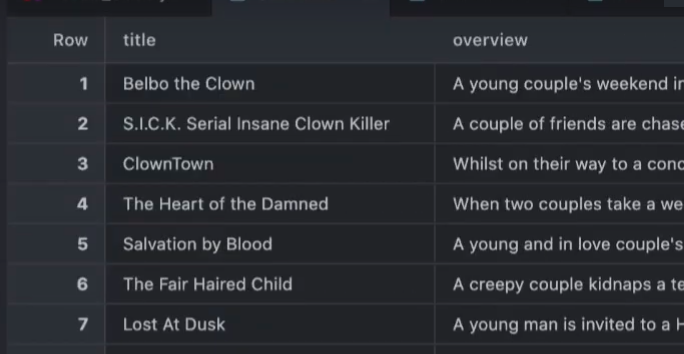

**Conclustion**
- Julia's package functions can be extended via multiple dispatch. This was pretty nice.
- As a penny pinching individual, working out this method was quite rewarding. (Yay, I saved 5 bucks) But it took lot of time reading OpenAI.jl's code.
- API's through https is very interesting. In the future, I would like to know more about GET, POST, DELETE etc.

Anyways, if you've read until this end of post, I would like to thank you. If you have any feedbacks or comments, feel free to connect via LinkedIn or email. Happy Coding!